Our goal is to make a list of participants across IETF groups. Once we've done that, it should be possible to evaluate patterns of participation: how many people participate, in which groups, how does affiliation, gender, RFC authorship or other characteristics relate to levels of participation, and a variety of other related questions.

Start by importing the necessary libraries.

In [67]:
%matplotlib inline
import bigbang.mailman as mailman
import bigbang.graph as graph
import bigbang.process as process
from bigbang.parse import get_date
from bigbang.archive import Archive
import bigbang.utils as utils
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
import pytz
import pickle
import os
import csv
import re
import scipy
import scipy.cluster.hierarchy as sch
import email

In [68]:
#pd.options.display.mpl_style = 'default' # pandas has a set of preferred graph formatting options
plt.rcParams['axes.facecolor'] = 'white'
import seaborn as sns
sns.set()
sns.set_style("white")

Let's start with a single IETF mailing list. (Later, we can expand to all current groups, or all IETF lists ever.)

In [69]:
list_url = 'https://www.ietf.org/mail-archive/text/perpass/' # perpass happens to be one that I subscribe to

ietf_archives_dir = '../../ietf-archives' # relative location of the ietf-archives directory/repo

list_archive = mailman.open_list_archives(list_url, ietf_archives_dir)
activity = Archive(list_archive).get_activity()

Opening 43 archive files


In [70]:
people = None
people = pd.DataFrame(activity.sum(0), columns=['perpass']) # sum the message count, rather than by date

In [71]:
people.describe()

,perpass
count,261.000000
mean,8.015326
std,18.733961
min,1.000000
25%,1.000000
50%,2.000000
75%,7.000000
max,231.000000


Now repeat, parsing the archives and collecting the activities for all the mailing lists in the corpus. To make this faster, we try to open pre-created `-activity.csv` files which contain the activity summary for the full list archive. These files are created with `bin/mail_to_activity.py` or might be included in the mailing list archive repository.

In [72]:
reload(mailman)

<module 'bigbang.mailman' from '/home/sb/projects/bigbang-multi/npdot-bigbang/bigbang/mailman.pyc'>

In [73]:
f = open('ietf_lists_normalized.txt', 'r')
ietf_lists = set(f.readlines()) # remove duplicates, which is a bug in list maintenance

In [74]:
list_activities = []

for list_url in ietf_lists:
    try:
        activity_summary = mailman.open_activity_summary(list_url, ietf_archives_dir)
        if activity_summary is not None:
            list_activities.append((list_url, activity_summary))
    except Exception as e:
        print str(e)

In [75]:
len(list_activities)

246

Merge all of the activity summaries together, so that every row is a "From" field, with a column for every mailing list and a cell that includes the number of messages sent to that list. This will be a very sparse, 2-d table. **This operation is a little slow.** Don't repeat this operation without recreating `people` from the cells above.

In [76]:
list_columns = []
for (list_url, activity_summary) in list_activities:
    list_name = mailman.get_list_name(list_url)
    activity_summary.rename(columns={'Message Count': list_name}, inplace=True) # name the message count column for the list
    people = pd.merge(people, activity_summary, how='outer', left_index=True, right_index=True)
    list_columns.append(list_name) # keep a list of the columns that specifically represent mailing list message counts

In [77]:
len(list_columns)

246

In [78]:
# the original message column was duplicated during the merge process, so we remove it here
people = people.drop(columns=['perpass_y'])
people = people.rename(columns={'perpass_x':'perpass'})

In [79]:
len(people.columns.values)

246

In [80]:
people.describe()

,perpass,yam,l2vpn,bgmp,ima,opsawg,bundled-domain-names,video-codec,domainrep,rpsec,...,ips,its,straw,eman,perc,payload,trill,ietf-nntp,spud,public-iri
count,261.000000,65.000000,602.000000,74.000000,207.000000,595.000000,17.000000,102.000000,80.000000,188.000000,...,1227.000000,202.000000,67.000000,115.000000,58.000000,207.000000,472.000000,1.0,78.000000,189.000000
mean,8.015326,12.861538,7.468439,2.148649,26.710145,8.710924,2.411765,5.441176,12.912500,10.861702,...,9.394458,9.831683,9.402985,21.252174,13.362069,8.304348,16.811441,0.0,9.884615,12.804233
std,18.733961,24.152431,18.298046,3.090784,76.347272,24.628358,2.670647,9.874032,25.200057,30.765493,...,49.606338,34.119652,16.891866,47.848783,20.529566,18.610445,63.417268,NaN,18.352240,31.897255
min,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.250000,1.000000
50%,2.000000,3.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,3.000000,2.000000,...,1.000000,2.000000,3.000000,3.000000,5.500000,3.000000,3.000000,0.0,4.000000,2.000000
75%,7.000000,10.000000,5.000000,1.000000,16.500000,6.000000,2.000000,5.000000,18.250000,6.000000,...,3.000000,6.000000,8.500000,13.000000,11.500000,7.000000,8.000000,0.0,8.750000,8.000000
max,231.000000,133.000000,197.000000,20.000000,799.000000,349.000000,11.000000,77.000000,192.000000,272.000000,...,1065.000000,364.000000,90.000000,274.000000,96.000000,145.000000,1114.000000,0.0,99.000000,252.000000


In [81]:
# not sure how the index ended up with NaN values, but need to change them to strings here so additional steps will work
new_index = people.index.fillna('missing')
people.index = new_index

Split out the email address and header name from the From header we started with.

In [82]:
froms = pd.Series(people.index)
emails = froms.apply(lambda x: email.utils.parseaddr(x)[1])
emails.index = people.index
names = froms.apply(lambda x: email.utils.parseaddr(x)[0])
names.index = people.index
people['email'] = emails
people['name'] = names

Let's create some summary statistical columns.

In [83]:
people['Total Messages'] = people[list_columns].sum(axis=1)
people['Number of Groups'] = people[list_columns].count(axis=1)
people['Median Messages per Group'] = people[list_columns].median(axis=1)

In [84]:
people['Total Messages'].sum()

652945.0

In [85]:
people['Total Messages'].describe()

count    23600.000000
mean        27.667161
std        159.443926
min          0.000000
25%          1.000000
50%          2.000000
75%         10.000000
max      13135.000000
Name: Total Messages, dtype: float64

In this corpus, **101,510** "people" sent a combined total of **1.2 million messages**. Most people sent only 1 message.

The vast majority of people send only a few messages, and to only a couple of lists. (These histograms use a log axis for Y, without which you couldn't even see the columns besides the first.)

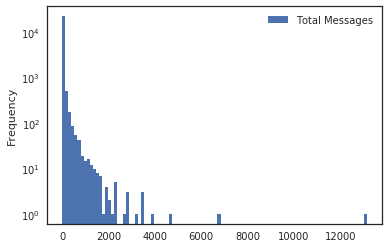

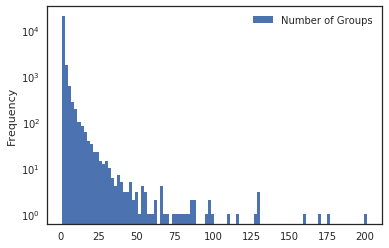

In [86]:
people[['Total Messages']].plot(kind='hist', bins=100, logy=True, logx=False)
people[['Number of Groups']].plot(kind='hist', bins=100, logy=True, logx=False)

In [87]:
people_nice = people.sort_values(by="Total Messages",ascending=False)[2:5000]
people_nice = people_nice.drop(columns=['email','name','Total Messages','Number of Groups','Median Messages per Group'])
people_nice = people_nice.fillna(0)
people_nice

,perpass,yam,l2vpn,bgmp,ima,opsawg,bundled-domain-names,video-codec,domainrep,rpsec,...,ips,its,straw,eman,perc,payload,trill,ietf-nntp,spud,public-iri
From,,,,,,,,,,,,,,,,,,,,,
Brian E Carpenter <brian.e.carpenter@gmail.com>,31.0,0.0,0.0,0.0,0.0,72.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0
Juergen Schoenwaelder <j.schoenwaelder@jacobs-university.de>,0.0,0.0,0.0,0.0,0.0,349.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,133.0,0.0,0.0,0.0,0.0,0.0,0.0
Peter Saint-Andre <stpeter@stpeter.im>,11.0,2.0,0.0,0.0,5.0,0.0,0.0,8.0,22.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140.0
Carsten Bormann <cabo@tzi.org>,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Alexandru Petrescu <alexandru.petrescu@gmail.com>,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,364.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The IESG <iesg-secretary@ietf.org>,0.0,4.0,40.0,4.0,36.0,29.0,0.0,2.0,9.0,4.0,...,28.0,2.0,15.0,15.0,1.0,29.0,72.0,0.0,0.0,0.0
Christer Holmberg <christer.holmberg@ericsson.com>,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,90.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
"""Pascal Thubert (pthubert)"" <pthubert@cisco.com>",0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Paul Kyzivat <pkyzivat@alum.mit.edu>,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,36.0,0.0,7.0,4.0,0.0,0.0,0.0,0.0


In [88]:
import networkx as nx

G = nx.Graph()

for group in people_nice.columns:
    G.add_node(group,type="group")
    
for name, data in people_nice.iterrows():
    G.add_node(name,type="person")
    
    for group, weight in data.iteritems():
        if weight > 0:
            G.add_edge(name,group,weight=weight)

In [92]:
len(G.nodes())

5244

In [93]:
len(G.edges())

25539

In [99]:
#nx.algorithms.bipartite.matrix.from_biadjacency_matrix(people_nice.as_matrix())

In [89]:
nx.is_bipartite(G)

True

In [105]:
pr = nx.pagerank(G)
nx.set_node_attributes(G,pr,name='pagerank')

In [113]:
sorted([node for node in list(G.nodes(data=True)) 
        if node[1]['type'] == 'group'], 
       key=lambda x: x[1]['pagerank'], 
       reverse =True)[:10]

[('ipv6', {'pagerank': 0.017967691597315434, 'type': 'group'}),
 ('tsvwg', {'pagerank': 0.011224620247845164, 'type': 'group'}),
 ('idr', {'pagerank': 0.010895327330516152, 'type': 'group'}),
 ('rtcweb', {'pagerank': 0.010265467736855487, 'type': 'group'}),
 ('oauth', {'pagerank': 0.010211550130800103, 'type': 'group'}),
 ('ips', {'pagerank': 0.009686548496137268, 'type': 'group'}),
 ('netmod', {'pagerank': 0.009622464204919258, 'type': 'group'}),
 ('behave', {'pagerank': 0.007374468305742979, 'type': 'group'}),
 ('tcpm', {'pagerank': 0.006958428403729585, 'type': 'group'}),
 ('hybi', {'pagerank': 0.006795729764959794, 'type': 'group'})]

In [114]:
sorted([node for node in list(G.nodes(data=True)) 
        if node[1]['type'] == 'person'], 
       key=lambda x: x[1]['pagerank'], 
       reverse =True)[:10]

[(u'Brian E Carpenter <brian.e.carpenter@gmail.com>',
  {'pagerank': 0.0029378488798716307, 'type': 'person'}),
 (u'The IESG <iesg-secretary@ietf.org>',
  {'pagerank': 0.0024043940283852466, 'type': 'person'}),
 (u'Carsten Bormann <cabo@tzi.org>',
  {'pagerank': 0.002295114056082805, 'type': 'person'}),
 (u'Alexandru Petrescu <alexandru.petrescu@gmail.com>',
  {'pagerank': 0.0022667855227384848, 'type': 'person'}),
 (u'Peter Saint-Andre <stpeter@stpeter.im>',
  {'pagerank': 0.0022308347407876358, 'type': 'person'}),
 (u'Juergen Schoenwaelder <j.schoenwaelder@jacobs-university.de>',
  {'pagerank': 0.002072609841211145, 'type': 'person'}),
 (u'"Pascal Thubert (pthubert)" <pthubert@cisco.com>',
  {'pagerank': 0.00191660952248379, 'type': 'person'}),
 (u'Christer Holmberg <christer.holmberg@ericsson.com>',
  {'pagerank': 0.0016025291302868107, 'type': 'person'}),
 (u'Stephen Farrell <stephen.farrell@cs.tcd.ie>',
  {'pagerank': 0.0015935851482847836, 'type': 'person'}),
 (u'Martin Thomson <

In [91]:
nx.write_gexf(G,'ietf-nice.gexf')

The median number of messages that a user sends to a group is also heavily weighted towards a small number, but the curve doesn't seem to drop off in the same extreme manner. There is a non-random tendency to send some messages to a group?

In [21]:
working[['Median Messages per Group']].plot(kind='hist', bins=100, logy=True)

NameError: name 'working' is not defined

Is there a relationship between the number of groups that a user has sent messages to and the number of messages that user has sent (total, or the median number to groups)?

In [22]:
working.plot.scatter('Number of Groups','Total Messages', xlim=(1,300), ylim=(1,20000), logx=False, logy=True)

NameError: name 'working' is not defined

In [ ]:
working = people[people['Total Messages'] > 1]

working['Total Messages (log)'] = np.log10(working['Total Messages'])
working['Number of Groups (log)'] = np.log10(working['Number of Groups'])


In [ ]:
sns.jointplot(x='Number of Groups',y='Total Messages (log)', data=working, kind="kde", xlim=(0,50), ylim=(0,3));

In [ ]:
people.plot.scatter('Number of Groups','Median Messages per Group', logx=True, logy=True, xlim=(1,300), ylim=(1,2000))

Can we learn groupings of the participants based on their message patterns?

In [ ]:
people.columns

In [ ]:
messages = people[people['Total Messages'] > 1]

messages = people.drop(columns=['email','name','Total Messages','Number of Groups','Median Messages per Group'])

In [ ]:
messages = messages.fillna(0)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5, whiten=True)
pca.fit(messages)

In [ ]:
pca.transform(messages)

In [ ]:
pca.explained_variance_ratio_

In [ ]:
component_df = pd.DataFrame(pca.transform(messages), columns=['PCA%i' % i for i in range(5)], index=messages.index)

In [ ]:
component_df.plot.scatter(x='PCA0',y='PCA1')